In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision

from scipy.stats import qmc, shapiro

In [2]:
import math
from torch import default_generator, randperm
from torch._utils import _accumulate
from torch.utils.data.dataset import Subset

def random_split(dataset, lengths,
                 generator=default_generator):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.

    If a list of fractions that sum up to 1 is given,
    the lengths will be computed automatically as
    floor(frac * len(dataset)) for each fraction provided.

    After computing the lengths, if there are any remainders, 1 count will be
    distributed in round-robin fashion to the lengths
    until there are no remainders left.

    Optionally fix the generator for reproducible results, e.g.:

    >>> random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
    >>> random_split(range(30), [0.3, 0.3, 0.4], generator=torch.Generator(
    ...   ).manual_seed(42))

    Args:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths or fractions of splits to be produced
        generator (Generator): Generator used for the random permutation.
    """
    if math.isclose(sum(lengths), 1) and sum(lengths) <= 1:
        subset_lengths: List[int] = []
        for i, frac in enumerate(lengths):
            if frac < 0 or frac > 1:
                raise ValueError(f"Fraction at index {i} is not between 0 and 1")
            n_items_in_split = int(
                math.floor(len(dataset) * frac)  # type: ignore[arg-type]
            )
            subset_lengths.append(n_items_in_split)
        remainder = len(dataset) - sum(subset_lengths)  # type: ignore[arg-type]
        # add 1 to all the lengths in round-robin fashion until the remainder is 0
        for i in range(remainder):
            idx_to_add_at = i % len(subset_lengths)
            subset_lengths[idx_to_add_at] += 1
        lengths = subset_lengths
        for i, length in enumerate(lengths):
            if length == 0:
                warnings.warn(f"Length of split at index {i} is 0. "
                              f"This might result in an empty dataset.")

    # Cannot verify that dataset is Sized
    if sum(lengths) != len(dataset):    # type: ignore[arg-type]
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths), generator=generator).tolist()  # type: ignore[call-overload]
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]

In [3]:
mnist_data = torchvision.datasets.MNIST('.', train=True, download=False,
                                        transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0,), (1,))]))

label: 5


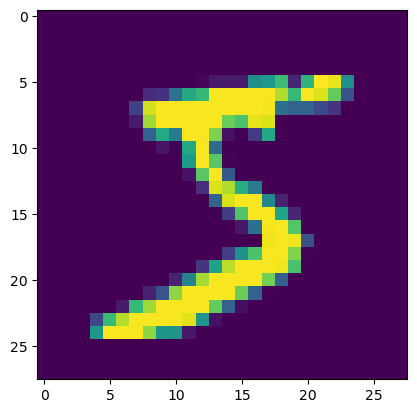

In [ ]:
# check data
for d in mnist_data:
  break
plt.imshow(d[0][0])
print(f'label: {d[1]}')

In [4]:
class Regressor(nn.Module):
    def __init__(self, hidden_size):
        super(Regressor, self).__init__()
        self.hidden_size = hidden_size
        self.conv1 = nn.Conv2d(1, hidden_size, kernel_size=3)
        self.conv2 = nn.Conv2d(hidden_size, hidden_size*2, kernel_size=3)
        self.conv3 = nn.Conv2d(hidden_size*2, hidden_size*4, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dense1 = nn.Linear(400*hidden_size, 500)
        self.drop1 = nn.Dropout(p=0.5)
        self.dense2 = nn.Linear(500, 100)
        self.drop2 = nn.Dropout(p=0.25)
        self.dense3 = nn.Linear(100, 20)
        self.dense4 = nn.Linear(20, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = nn.Softplus()(self.conv2(x))
        x = self.pool(x)
        x = nn.Softplus()(self.conv3(x))
        x = nn.Softplus()(self.dense1(x.view(-1, 400*self.hidden_size)))
        x = self.drop1(x)
        x = nn.Softplus()(self.dense2(x))
        x = self.drop2(x)
        x = nn.Softplus()(self.dense3(x))
        x = self.dense4(x)
        return x

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        x = nn.Tanh()(x)
        x = self.output(x)
        return x

In [57]:
math.log(2)

0.6931471805599453

In [60]:
def log_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    def _log_cosh(x: torch.Tensor) -> torch.Tensor:
        return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)
    return torch.mean(_log_cosh(y_pred - y_true))

def log_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    def _log_cosh(x: torch.Tensor) -> torch.Tensor:
        return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)
    return _log_cosh(y_pred - y_true)

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        return log_cosh_loss(y_pred, y_true)

In [38]:
def train_epoch(model, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    model.train()
    train_loss = 0.0
    for x, y in dataloader:
        y_pred = model(x.float().to(device))
        #y = (y-y_mean)/y_std
        #loss = torch.nn.L1Loss()(y_pred.reshape(-1), y.float().to(device))
        loss = torch.mean(LogCoshLoss()(y_pred.reshape(-1), y.float().to(device)))
        train_loss += loss.cpu().item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss / len(dataloader)

def valid_epoch(model, device, dataloader):
    # Set train mode for both the encoder and the decoder
    model.eval()
    valid_loss = 0.0

    for x, y in dataloader:
        y_pred = model(x.float().to(device))
        #y = (y-y_mean)/y_std
        loss = torch.nn.L1Loss()(y_pred.reshape(-1), y.float().to(device))  #MSELoss
        valid_loss += loss.cpu().item()
    
    return valid_loss / len(dataloader)

In [39]:
def train_model(model, train_loader, valid_loader, lr, device, save_path, epochs=100):
    model = model.to(device)
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-6)
    #optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-6)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5)

    bar = tqdm(range(epochs))
    train_losses = []
    valid_losses = []
    min_val_loss = np.inf
    patience = 50
    patience_step = 0
    for epoch in bar:
        train_loss = train_epoch(model, device, train_loader, optimizer)
        valid_loss = valid_epoch(model, device, valid_loader)
        bar.set_description(f"\n EPOCH {epoch + 1}/{epochs} \t train loss {train_loss:.6f}  valid loss {valid_loss:.6f}")#  valid RMSE {np.sqrt(valid_loss):.5f}")
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if valid_loss < min_val_loss:
            min_val_loss = valid_loss
            torch.save(model.state_dict(), save_path)
        else:
            scheduler.step(valid_loss)
            patience_step += 1
        if patience_step > patience:
            break
    return train_losses, valid_losses

In [40]:
lr=0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data, valid_data, test_data = random_split(mnist_data, [0.8, 0.1, 0.1])

batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, drop_last=False)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]
 EPOCH 1/3 	 train loss 0.755577  valid loss 0.520692:   0%|                                    | 0/3 [00:29<?, ?it/s]
 EPOCH 1/3 	 train loss 0.755577  valid loss 0.520692:  33%|█████████▎                  | 1/3 [00:30<01:00, 30.01s/it]
 EPOCH 2/3 	 train loss 0.255029  valid loss 0.363127:  33%|█████████▎                  | 1/3 [00:59<01:00, 30.01s/it]
 EPOCH 2/3 	 train loss 0.255029  valid loss 0.363127:  67%|██████████████████▋         | 2/3 [00:59<00:29, 29.81s/it]
 EPOCH 3/3 	 train loss 0.146988  valid loss 0.249474:  67%|██████████████████▋         | 2/3 [01:29<00:29, 29.81s/it]
 EPOCH 3/3 	 train loss 0.146988  valid loss 0.249474: 100%|████████████████████████████| 3/3 [01:29<00:00, 29.95s/it]
 EPOCH 3/3 	 train loss 0.146988  valid loss 0.249474: 100%|████████████████████████████| 3/3 [01:29<00:00, 29.93s/it]


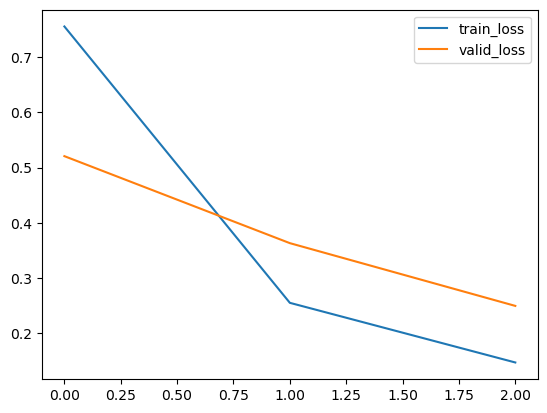

In [61]:
retrain = False
save_path = "models/teacher_test.pt"
teacher_model = Regressor(hidden_size=5)
if retrain:
    train_losses, valid_losses = train_model(teacher_model, train_loader, valid_loader, lr, device, save_path, epochs=3)
    plt.plot(np.arange(len(train_losses)), train_losses, label='train_loss')
    plt.plot(np.arange(len(valid_losses)), valid_losses, label='valid_loss')
    plt.legend()
else:
    teacher_model.load_state_dict(torch.load("models/teacher.pt"))

In [62]:
teacher_model = Regressor(hidden_size=10)
teacher_model.load_state_dict(torch.load("models/teacher.pt"))
#teacher_model = Regressor(hidden_size=5)
#teacher_model.load_state_dict(torch.load("models/teacher_h5.pt"))
teacher_model.eval().to(device)
y_pred = []
y_test = []
with torch.no_grad():
    for x, y in test_loader:
        pred = teacher_model(x.float().to(device))
        pred = list(pred.cpu().detach().numpy())
        y_pred.append(pred)
        y_test.append(list(y.cpu().numpy()))
#y_pred = np.array(y_pred).reshape(-1)*y_std + y_mean
y_pred = np.array(y_pred).reshape(-1)
y_test = np.array(y_test).reshape(-1)
print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")

R2 score: 0.9970707453554859
RMSE: 0.1566086966829624


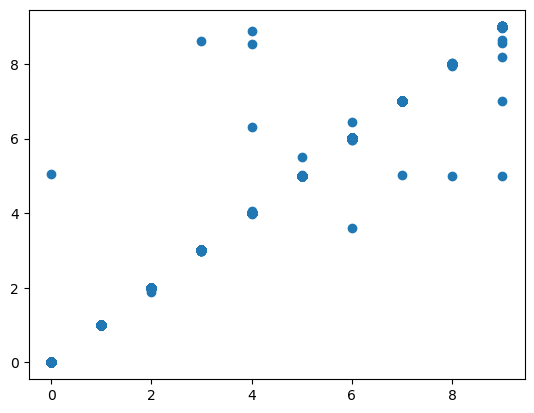

In [63]:
plt.scatter(y_test, y_pred)

tensor([[0.0015]], device='cuda:0', grad_fn=<AddmmBackward0>)
label: 0


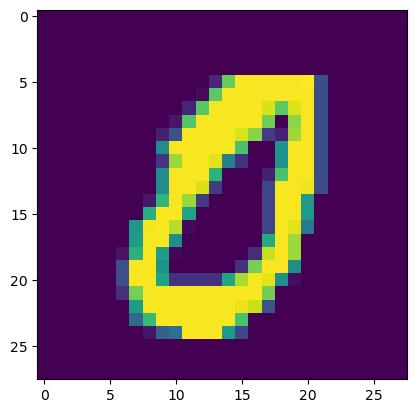

In [11]:
d = mnist_data.__getitem__(81)
y_p = teacher_model(torch.unsqueeze(d[0].to(device), 0))
print(y_p)
plt.imshow(d[0][0])
print(f'label: {d[1]}')

In [12]:
# calculate the mean and std for each pixel
recalculate = False
if recalculate:
    x_sum = torch.zeros((28, 28))
    x_sum_sq = torch.zeros((28, 28))
    for i, _ in tqdm(mnist_data, total=len(mnist_data)):
        for row in range(28):
            for col in range(28):
                px_value = i[0, row, col]
                x_sum[row, col] += px_value
                x_sum_sq[row, col] += px_value*px_value
    x_mean = x_sum/len(mnist_data)
    x_var = (x_sum_sq - (x_sum*x_sum)/len(mnist_data))/(len(mnist_data)-1)
    x_mean = x_mean.numpy()
    x_var = x_var.numpy()
else:
    x_mean = np.load("MNIST/pixel_stats/x_mean.npy")
    x_var = np.load("MNIST/pixel_stats/x_var.npy")
x_std = np.sqrt(x_var)

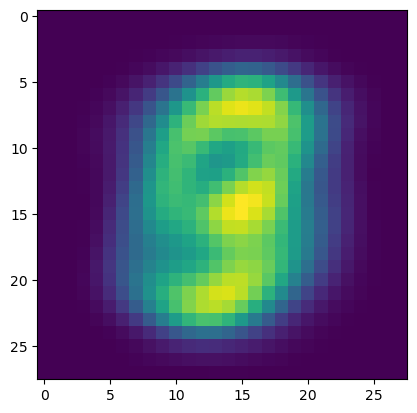

In [13]:
plt.imshow(x_mean)

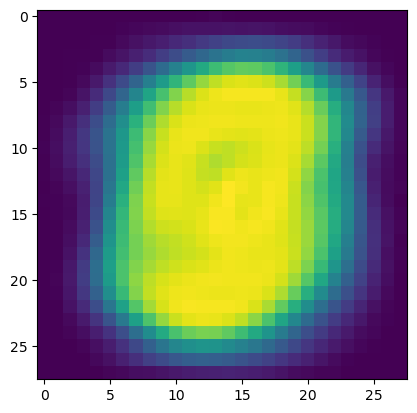

In [14]:
plt.imshow(x_std)

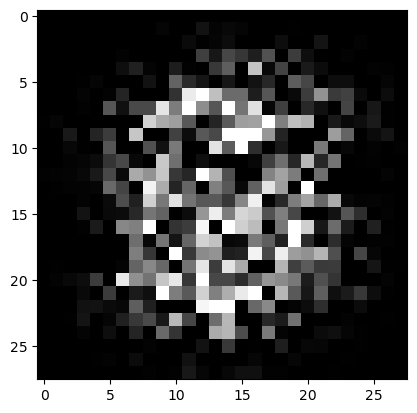

In [196]:
x_p = np.random.normal(x_mean.reshape(-1), x_std.reshape(-1), (1, 784))
x_p = np.clip(x_p, 0, 1)
plt.imshow(x_p.reshape(28,28), cmap='gray')
plt.savefig('plots/random.png')

In [19]:
# Train generator

def generator_loss(x: torch.Tensor, teacher_model, student_model):
    teacher_model.eval().to(device)
    student_model.eval().to(device)
    teacher_label = teacher_model(x.float().to(device))
    student_pred = student_model(x.float().to(device))
    return -LogCoshLoss()(teacher_label, student_pred), student_pred

def generator_loss_L1(x: torch.Tensor, teacher_model, student_model):
    teacher_model.eval().to(device)
    student_model.eval().to(device)
    teacher_label = teacher_model(x.float().to(device))
    student_pred = student_model(x.float().to(device))
    return -torch.abs(teacher_label - student_pred), student_pred

In [29]:
class FunctionWrapper(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self, m, d=28):
        super().__init__()
        #weights = torch.randn(m, 1, d, d).to(device)
        weights = np.random.normal(x_mean.reshape(-1), x_std.reshape(-1), (m, d*d))
        weights = torch.from_numpy(weights.reshape(m, 1, d, d))
        weights = torch.clip(weights, 0, 1)
        self.weights = nn.Parameter(weights.float())
        
    def forward(self, teacher_model, student_model):
        teacher_model.eval().to(device)
        student_model.eval().to(device)
        teacher_label = teacher_model(self.weights.to(device))
        student_pred = student_model(self.weights.to(device))
        #return -(teacher_label - student_pred)**2, student_pred
        return -LogCoshLoss()(teacher_label, student_pred), student_pred, teacher_label

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]
 EPOCH 1/2000 	 train loss 29.547125  valid loss 2.84536:   0%|                              | 0/2000 [00:02<?, ?it/s]
 EPOCH 1/2000 	 train loss 29.547125  valid loss 2.84536:   0%|                    | 1/2000 [00:02<1:18:31,  2.36s/it]
 EPOCH 2/2000 	 train loss 10.769037  valid loss 3.52048:   0%|                    | 1/2000 [00:04<1:18:31,  2.36s/it]
 EPOCH 2/2000 	 train loss 10.769037  valid loss 3.52048:   0%|                    | 2/2000 [00:04<1:13:35,  2.21s/it]
 EPOCH 3/2000 	 train loss 10.388572  valid loss 3.17768:   0%|                    | 2/2000 [00:06<1:13:35,  2.21s/it]
 EPOCH 3/2000 	 train loss 10.388572  valid loss 3.17768:   0%|                    | 3/2000 [00:06<1:11:22,  2.14s/it]
 EPOCH 4/2000 	 train loss 9.779730  valid loss 2.84562:   0%|                     | 3/2000 [00:08<1:11:22,  2.14s/it]
 EPOCH 4/2000 	 train loss 9.779730  valid loss

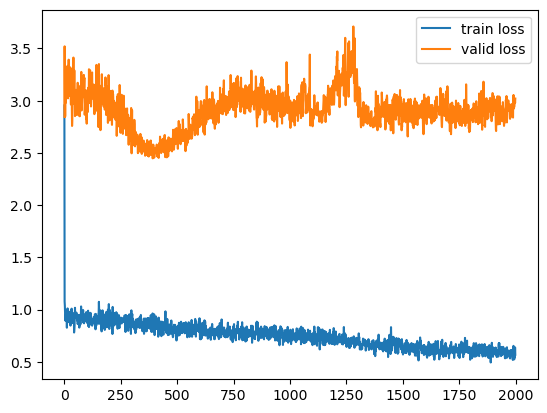

In [213]:
# Train student with baseline method 
retrain = True
continue_training = False
teacher_model.eval()
epochs = 2000
ns = 10
m = 50
bar = tqdm(range(epochs))
student_size = 5
baseline_model = Regressor(hidden_size=student_size)
baseline_save_path = "models/baseline.pt"
if continue_training:
    baseline_model.load_state_dict(torch.load(baseline_save_path))
baseline_model.train().to(device)

lr = 0.001
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=lr)

train_losses = []
valid_losses = []
min_val_loss = np.inf

if retrain:
    for epoch in bar:
        train_loss = 0.0
        for i in range(ns):
            batch_xp = np.random.normal(x_mean.reshape(-1), x_std.reshape(-1), (m, 784)).reshape(m, 1, 28, 28)
            batch_xp = torch.from_numpy(batch_xp).float().to(device)
            batch_xp = torch.clip(batch_xp, 0, 1)
            batch_ytp = teacher_model(batch_xp)
            batch_ysp = baseline_model(batch_xp) 
            loss = torch.mean(LogCoshLoss()(batch_ytp, batch_ysp))
            train_loss += loss.cpu().item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          
        valid_loss = valid_epoch(baseline_model, device, valid_loader)
        train_losses.append(train_loss/ns)
        valid_losses.append(valid_loss)
        bar.set_description(f"\n EPOCH {epoch + 1}/{epochs} \t train loss {train_loss:.6f}  valid loss {valid_loss:.5f}")
        if valid_loss < min_val_loss:
            torch.save(baseline_model.state_dict(), baseline_save_path)
            min_val_loss = valid_loss

    plt.plot(np.arange(len(train_losses)), train_losses, label='train loss')
    plt.plot(np.arange(len(valid_losses)), valid_losses, label='valid loss')
    plt.legend()

In [214]:
baseline_model = Regressor(hidden_size=student_size)
baseline_model.load_state_dict(torch.load("models/baseline.pt"))

<All keys matched successfully>

In [215]:
baseline_model.eval().to(device)
y_pred = []
y_test = []
with torch.no_grad():
    for x, y in test_loader:
        pred = baseline_model(x.float().to(device))
        pred = list(pred.cpu().detach().numpy())
        y_pred.append(pred)
        y_test.append(list(y.cpu().numpy()))
y_pred = np.array(y_pred).reshape(-1)
y_test = np.array(y_test).reshape(-1)
print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")

R2 score: -0.0138462410254645
RMSE: 2.9135559296352005


 EPOCH 4/4 	 train loss -3.521750: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 40.37it/s]


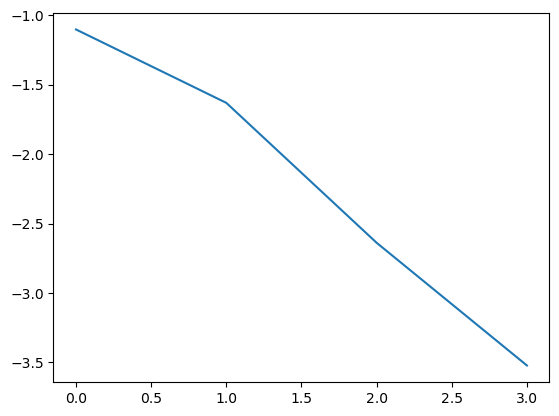

In [89]:
# direct optimization on generator loss wrt input x
teacher_model.eval()
epochs = 4
m = 50
train_losses = []
fun = FunctionWrapper(m, 28)
optimizer_direct = torch.optim.RMSprop(fun.parameters(), lr=0.1, weight_decay=1e-5)
bar = tqdm(range(epochs))
for epoch in bar:
    loss, student_pred, teacher_pred = fun(teacher_model, baseline_model)
    
    l1_norm = torch.zeros(batch_size)
    for p in fun.parameters():
        l1_norm += torch.sum(torch.abs(p.view(batch_size, -1)), dim=1)
    l1_norm = l1_norm/batch_size
    loss = torch.mean(loss + 1e-5 * l1_norm.to(device))
    
    optimizer_direct.zero_grad()
    loss.backward()
    optimizer_direct.step()
    train_loss = loss.cpu().item()
    train_losses.append(train_loss)
    bar.set_description(f"\n EPOCH {epoch + 1}/{epochs} \t train loss {train_loss:.6f}")
plt.plot(np.arange(len(train_losses)), train_losses, label='train loss') 

 EPOCH 4/4 	 train loss -1.763198: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 63.73it/s]


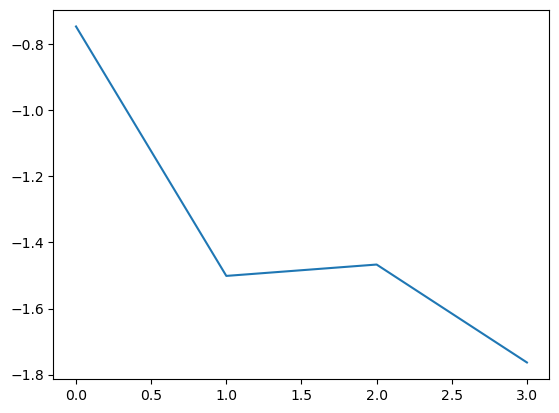

In [90]:
# train generator to generate x that give large generator loss
teacher_model.eval()
epochs = 4
ns = 1
m = 50
bar = tqdm(range(epochs))
generator = Generator(50, 500, 28*28).to(device)

optimizer = torch.optim.RMSprop(generator.parameters(), lr=0.001, weight_decay=1e-6)

train_losses = []
generator.train()
for epoch in bar:
    train_loss = 0.0
    for i in range(ns):
        # generate synthetic data
        xg = np.random.normal(loc=0.0, scale=1.0, size=(m, 50))
        xg = torch.from_numpy(xg).float()
        xg = generator(xg.to(device))
        loss, student_pred = generator_loss(xg.view(m, 1, 28, 28), teacher_model, baseline_model)
        loss = torch.mean(loss + 1e-5 * torch.sum(torch.abs(xg.view(batch_size, -1)), dim=1))
        train_loss += loss.cpu().item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_losses.append(train_loss/ns)
    bar.set_description(f"\n EPOCH {epoch + 1}/{epochs} \t train loss {train_loss/ns:.6f}")
plt.plot(np.arange(len(train_losses)), train_losses, label='train loss')

In [91]:
# random sample (normal)
xg_normal = np.random.normal(x_mean.reshape(-1), x_std.reshape(-1), (m, 784)).reshape(m, 1, 28, 28)
xg_normal = np.clip(xg_normal, 0, 1)
loss_S_normal, _ = generator_loss_L1(torch.from_numpy(xg_normal), teacher_model, baseline_model)

# random sample (qmc)
sampler = qmc.LatinHypercube(28*28)
xg_lhs = sampler.random(n=m)
xg_lhs = xg_lhs.reshape(m, 1, 28, 28)
loss_S_lhs, _ = generator_loss_L1(torch.from_numpy(xg_lhs), teacher_model, baseline_model)

# generator
generator.eval()
with torch.no_grad():
    xg_generator = torch.randn(m, 50).to(device)
    xg_generator = generator(xg_generator)
    xg_generator = xg_generator.view(m, 1, 28, 28)
loss_S_generator, _ = generator_loss_L1(xg_generator, teacher_model, baseline_model)

# direct optimization (gradient descent)
xg_direct = nn.utils.parameters_to_vector(fun.weights).view(m, 1, 28, 28)
loss_S_direct, _ = generator_loss_L1(xg_direct, teacher_model, baseline_model)

In [92]:
loss_S_normal = -loss_S_normal.detach().cpu().numpy()
loss_S_lhs = -loss_S_lhs.detach().cpu().numpy()
loss_S_generator = -loss_S_generator.detach().cpu().numpy()
loss_S_direct = -loss_S_direct.detach().cpu().numpy()

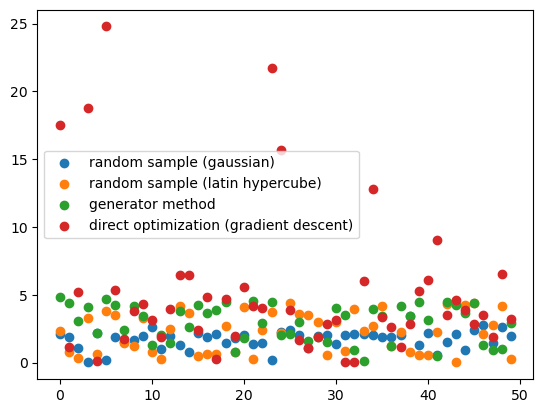

In [93]:
plt.scatter(np.arange(len(xg_normal)), loss_S_normal, label='random sample (gaussian)')
plt.scatter(np.arange(len(xg_normal)), loss_S_lhs, label='random sample (latin hypercube)')
plt.scatter(np.arange(len(xg_normal)), loss_S_generator, label='generator method')
plt.scatter(np.arange(len(xg_normal)), loss_S_direct, label='direct optimization (gradient descent)')
plt.legend()

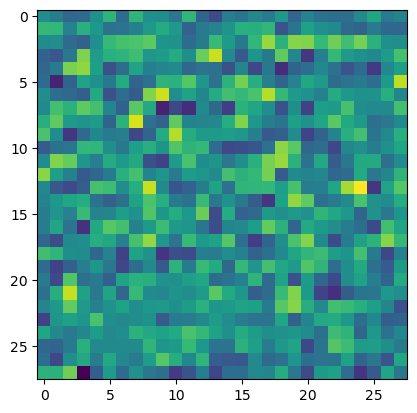

In [94]:
plt.imshow(xg_generator[0][0].cpu().numpy())

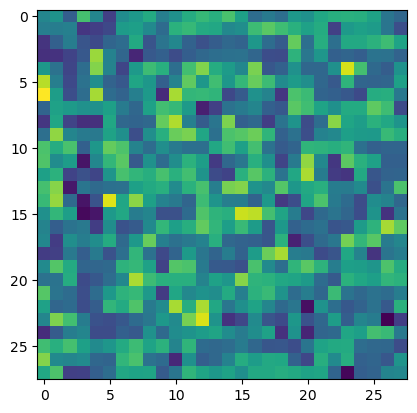

In [95]:
plt.imshow(xg_direct[0][0].detach().cpu().numpy())

In [96]:
torch.cuda.empty_cache() 

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]
 EPOCH 1/1000 	 xg loss 0.452647  xp loss 0.000000  valid MAE 2.51342:   0%|                 | 0/1000 [00:06<?, ?it/s]
 EPOCH 1/1000 	 xg loss 0.452647  xp loss 0.000000  valid MAE 2.51342:   0%|       | 1/1000 [00:06<1:49:14,  6.56s/it]
 EPOCH 2/1000 	 xg loss 0.108829  xp loss 0.000000  valid MAE 2.31241:   0%|       | 1/1000 [00:12<1:49:14,  6.56s/it]
 EPOCH 2/1000 	 xg loss 0.108829  xp loss 0.000000  valid MAE 2.31241:   0%|       | 2/1000 [00:12<1:47:04,  6.44s/it]
 EPOCH 3/1000 	 xg loss 0.121309  xp loss 0.000000  valid MAE 2.25628:   0%|       | 2/1000 [00:18<1:47:04,  6.44s/it]
 EPOCH 3/1000 	 xg loss 0.121309  xp loss 0.000000  valid MAE 2.25628:   0%|       | 3/1000 [00:18<1:43:58,  6.26s/it]
 EPOCH 4/1000 	 xg loss 0.107898  xp loss 0.000000  valid MAE 2.23833:   0%|       | 3/1000 [00:25<1:43:58,  6.26s/it]
 EPOCH 4/1000 	 xg loss 0.107898  xp loss 0.000

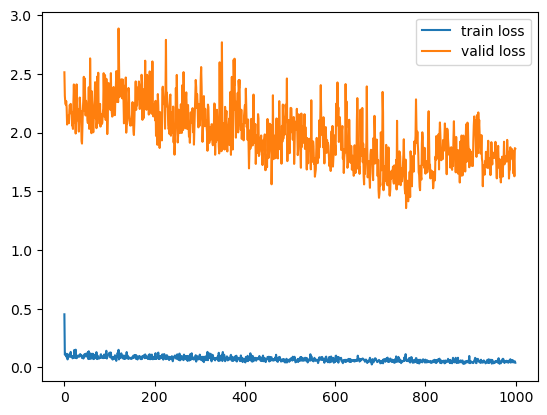

In [181]:
# train student
method = 'direct_optimizer'
student_size = 5
student_save_path = os.path.join("models", f"student_{method}.pt")
if method == 'generator':
    generator = Generator(50, 500, 28*28).to(device)
    optimizerG = torch.optim.RMSprop(generator.parameters(), lr=1e-3, weight_decay=1e-5)
    generator.train()

#student = Regressor(hidden_size=student_size).to(device)
optimizerS = torch.optim.RMSprop(student.parameters(), lr=1e-3, weight_decay=1e-5)
#optimizerS = torch.optim.Adam(student.parameters(), lr=1e-3)
student.train()

dim_z = 50
epsilon = 1e-6
beta = 1e-6
gamma = 1
batch_size = 50
n_iter = 2000
n_g = 20
n_s = 10
teacher_model.eval().to(device)
bar = tqdm(range(n_iter))

train_losses = []
valid_losses = []
min_val_loss = np.inf
for it in bar:

    #alpha = 1 - (it+1)/n_iter
    alpha = 1

    # generator training
    if method == 'generator':
        rand_labels = torch.randint(0, 10, (batch_size, 1)).to(device)
        for _ in range(n_g):

            batch_z = torch.randn(batch_size, dim_z).to(device)
            batch_xg = generator(batch_z)
            batch_xg = torch.clip(batch_xg, 0, 1)
            batch_ytg = teacher_model(batch_xg.view(batch_size, 1, 28, 28))
            batch_ysg = student(batch_xg.view(batch_size, 1, 28, 28))

            #G_loss = torch.mean( - torch.square(batch_ytg - batch_ysg) + beta * torch.sum(torch.square(batch_xg)) + gamma * torch.square(batch_ysg) )            
            G_loss = torch.mean(-epsilon * LogCoshLoss()(batch_ytg, batch_ysg) + beta * torch.sum(torch.abs(batch_xg.view(batch_size, -1)), dim=1) + gamma * (batch_ytg - rand_labels)**2)
            #G_loss = torch.mean((batch_ytg - rand_labels)**2)
            
            optimizerG.zero_grad()
            G_loss.backward()
            optimizerG.step()

    # student training
    xg_losses = 0.0
    xp_losses = 0.0
    for _ in range(n_s):
        if method == 'generator':
            batch_z = torch.randn(batch_size, dim_z).to(device)
            batch_xg = generator(batch_z).view(batch_size, 1, 28, 28)
        elif method == 'direct_optimizer':
            fun = FunctionWrapper(batch_size, 28)
            optimizer_direct = torch.optim.RMSprop(fun.parameters(), lr=0.01)
            rand_labels = torch.randint(0, 10, (batch_size, 1)).to(device)
            for i in range(20):
                direct_loss, student_pred, teacher_pred = fun(teacher_model, student)
                l1_norm = torch.zeros(batch_size)
                for p in fun.parameters():
                    l1_norm += torch.sum(torch.abs(p.view(batch_size, -1)), dim=1)
                direct_loss = torch.mean(epsilon * direct_loss + beta * l1_norm.to(device)/batch_size + gamma * (teacher_pred.to(device) - rand_labels)**2)
                #direct_loss = torch.mean((teacher_pred.to(device) - rand_labels)**2)
                optimizer_direct.zero_grad()
                direct_loss.backward()
                optimizer_direct.step()
            batch_xg = nn.utils.parameters_to_vector(fun.weights).view(batch_size, 1, 28, 28).to(device)
        
        batch_xg = torch.clip(batch_xg, 0, 1)
        batch_ytg = teacher_model(batch_xg)
        batch_ysg = student(batch_xg)

        #batch_xp = torch.randn(batch_size, 1, 28, 28).to(device)
        batch_xp = np.random.normal(x_mean.reshape(-1), x_std.reshape(-1), (m, 784)).reshape(m, 1, 28, 28)
        batch_xp = torch.from_numpy(batch_xp).float().to(device)
        batch_xp = torch.clip(batch_xp, 0, 1)
        batch_ytp = teacher_model(batch_xp)
        batch_ysp = student(batch_xp) 

        #xg_loss = alpha * torch.square(batch_ytg - batch_ysg)
        #xp_loss = (1 - alpha) * torch.square(batch_ytp - batch_ysp) 
        xg_loss = alpha * torch.mean(LogCoshLoss()(batch_ytg, batch_ysg))
        xp_loss = (1 - alpha) * torch.mean(LogCoshLoss()(batch_ytp, batch_ysp))
        
        S_loss = xg_loss + xp_loss

        optimizerS.zero_grad()
        S_loss.backward()
        optimizerS.step()
        
        xg_losses += torch.mean(xg_loss).cpu().item()
        xp_losses += torch.mean(xp_loss).cpu().item()
        
    valid_loss = valid_epoch(student, device, valid_loader)
    if valid_loss < min_val_loss:
        torch.save(student.state_dict(), student_save_path)
        min_val_loss = valid_loss
    
    bar.set_description(f"\n EPOCH {it + 1}/{n_iter} \t xg loss {xg_losses/n_s:.6f}  xp loss {xp_losses/n_s:.6f}  valid MAE {valid_loss:.5f}")
    train_losses.append((xg_losses + xp_losses)/n_s)
    valid_losses.append(valid_loss)
    
plt.plot(np.arange(len(train_losses)), train_losses, label='train loss')
plt.plot(np.arange(len(valid_losses)), valid_losses, label='valid loss')
plt.legend()

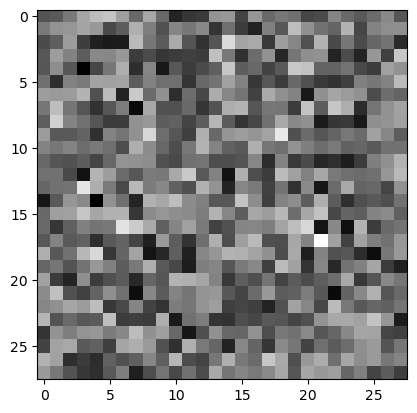

In [206]:
plt.imshow(batch_xg[8].view(28, 28).detach().cpu().numpy(), cmap='gray')
plt.savefig('plots/generator.png')

In [162]:
student = Regressor(hidden_size=student_size).to(device)
student.load_state_dict(torch.load('models/student_generator.pt'))

student.eval().to(device)
y_pred = []
y_test = []
with torch.no_grad():
    for x, y in test_loader:
        pred = student(x.float().to(device))
        pred = list(pred.cpu().detach().numpy())
        y_pred.append(pred)
        y_test.append(list(y.cpu().numpy()))
y_pred = np.array(y_pred).reshape(-1)
y_test = np.array(y_test).reshape(-1)
print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"MAE: {np.mean(np.abs(y_test - y_pred))}")

R2 score: 0.0027699421083982045
RMSE: 2.8895817907922816
MAE: 2.4277238958676657


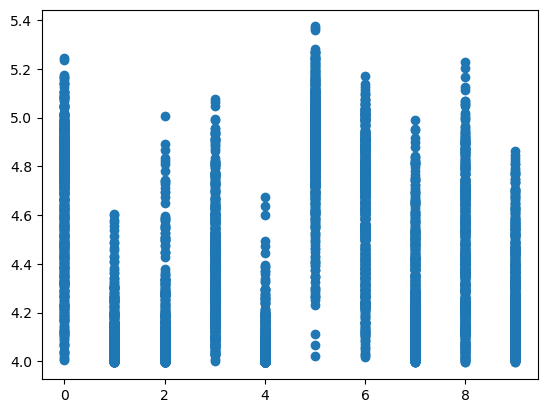

In [163]:
plt.scatter(y_test, y_pred)

In [185]:
student = Regressor(hidden_size=student_size).to(device)
student.load_state_dict(torch.load('models/student_direct_optimizer.pt'))

student.eval().to(device)
y_pred = []
y_test = []
with torch.no_grad():
    for x, y in test_loader:
        pred = student(x.float().to(device))
        pred = list(pred.cpu().detach().numpy())
        y_pred.append(pred)
        y_test.append(list(y.cpu().numpy()))
y_pred = np.array(y_pred).reshape(-1)
y_test = np.array(y_test).reshape(-1)
print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"MAE: {np.mean(np.abs(y_test - y_pred))}")

R2 score: 0.41792347438580435
RMSE: 2.2076354244436907
MAE: 1.3455986848771573


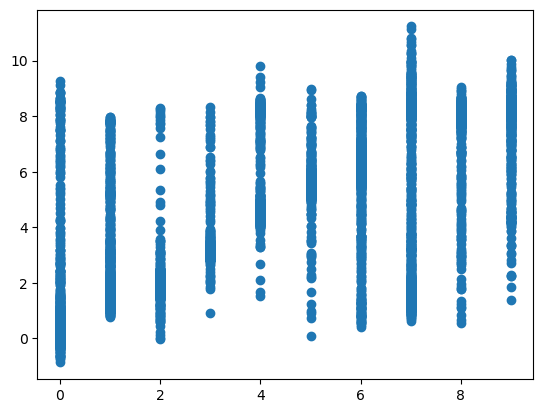

In [186]:
plt.scatter(y_test, y_pred)

In [197]:
# Run for 5 replicates

dim_z = 50
epsilon = 1e-7
beta = 1e-7
gamma = 1
batch_size = 50
n_iter = 2000
n_g = 20
n_s = 10
teacher_model.eval().to(device)
student_size = 5

replicates = 5
all_results = np.zeros((5, 2))
for r in range(replicates):
    for c, method in enumerate(['direct_optimizer', 'generator']):
        # train student
        student_save_path = os.path.join("models", f"student_{method}.pt")
        if method == 'generator':
            generator = Generator(50, 500, 28*28).to(device)
            optimizerG = torch.optim.RMSprop(generator.parameters(), lr=1e-3, weight_decay=1e-5)
            generator.train()

        student = Regressor(hidden_size=student_size).to(device)
        optimizerS = torch.optim.RMSprop(student.parameters(), lr=1e-3, weight_decay=1e-5)
        student.train()

        bar = tqdm(range(n_iter))

        train_losses = []
        valid_losses = []
        min_val_loss = np.inf
        for it in bar:

            #alpha = 1 - (it+1)/n_iter
            alpha = 1

            # generator training
            if method == 'generator':
                rand_labels = torch.randint(0, 10, (batch_size, 1)).to(device)
                for _ in range(n_g):

                    batch_z = torch.randn(batch_size, dim_z).to(device)
                    batch_xg = generator(batch_z)
                    batch_xg = torch.clip(batch_xg, 0, 1)
                    batch_ytg = teacher_model(batch_xg.view(batch_size, 1, 28, 28))
                    batch_ysg = student(batch_xg.view(batch_size, 1, 28, 28))
          
                    G_loss = torch.mean(-epsilon * LogCoshLoss()(batch_ytg, batch_ysg) + beta * torch.sum(torch.abs(batch_xg.view(batch_size, -1)), dim=1) + gamma * (batch_ytg - rand_labels)**2)

                    optimizerG.zero_grad()
                    G_loss.backward()
                    optimizerG.step()

            # student training
            xg_losses = 0.0
            xp_losses = 0.0
            for _ in range(n_s):
                if method == 'generator':
                    batch_z = torch.randn(batch_size, dim_z).to(device)
                    batch_xg = generator(batch_z).view(batch_size, 1, 28, 28)
                elif method == 'direct_optimizer':
                    fun = FunctionWrapper(batch_size, 28)
                    optimizer_direct = torch.optim.RMSprop(fun.parameters(), lr=0.01)
                    rand_labels = torch.randint(0, 10, (batch_size, 1)).to(device)
                    for i in range(20):
                        direct_loss, student_pred, teacher_pred = fun(teacher_model, student)
                        l1_norm = torch.zeros(batch_size)
                        for p in fun.parameters():
                            l1_norm += torch.sum(torch.abs(p.view(batch_size, -1)), dim=1)
                        direct_loss = torch.mean(epsilon * direct_loss + beta * l1_norm.to(device)/batch_size + gamma * (teacher_pred.to(device) - rand_labels)**2)
                        #direct_loss = torch.mean((teacher_pred.to(device) - rand_labels)**2)
                        optimizer_direct.zero_grad()
                        direct_loss.backward()
                        optimizer_direct.step()
                    batch_xg = nn.utils.parameters_to_vector(fun.weights).view(batch_size, 1, 28, 28).to(device)

                batch_xg = torch.clip(batch_xg, 0, 1)
                batch_ytg = teacher_model(batch_xg)
                batch_ysg = student(batch_xg)

                #batch_xp = torch.randn(batch_size, 1, 28, 28).to(device)
                batch_xp = np.random.normal(x_mean.reshape(-1), x_std.reshape(-1), (m, 784)).reshape(m, 1, 28, 28)
                batch_xp = torch.from_numpy(batch_xp).float().to(device)
                batch_xp = torch.clip(batch_xp, 0, 1)
                batch_ytp = teacher_model(batch_xp)
                batch_ysp = student(batch_xp) 

                #xg_loss = alpha * torch.square(batch_ytg - batch_ysg)
                #xp_loss = (1 - alpha) * torch.square(batch_ytp - batch_ysp) 
                xg_loss = alpha * torch.mean(LogCoshLoss()(batch_ytg, batch_ysg))
                xp_loss = (1 - alpha) * torch.mean(LogCoshLoss()(batch_ytp, batch_ysp))

                S_loss = xg_loss + xp_loss

                optimizerS.zero_grad()
                S_loss.backward()
                optimizerS.step()

                xg_losses += torch.mean(xg_loss).cpu().item()
                xp_losses += torch.mean(xp_loss).cpu().item()

            valid_loss = valid_epoch(student, device, valid_loader)
            if valid_loss < min_val_loss:
                torch.save(student.state_dict(), student_save_path)
                min_val_loss = valid_loss

            bar.set_description(f"\n EPOCH {it + 1}/{n_iter} \t xg loss {xg_losses/n_s:.6f}  xp loss {xp_losses/n_s:.6f}  valid MAE {valid_loss:.5f}")
            train_losses.append((xg_losses + xp_losses)/n_s)
            valid_losses.append(valid_loss)
            
            
        # save results
        student = Regressor(hidden_size=student_size).to(device)
        student.load_state_dict(torch.load(student_save_path))

        student.eval().to(device)
        y_pred = []
        y_test = []
        with torch.no_grad():
            for x, y in test_loader:
                pred = student(x.float().to(device))
                pred = list(pred.cpu().detach().numpy())
                y_pred.append(pred)
                y_test.append(list(y.cpu().numpy()))
        y_pred = np.array(y_pred).reshape(-1)
        y_test = np.array(y_test).reshape(-1)
        mae = np.mean(np.abs(y_test - y_pred))
        print(f"R2 score: {r2_score(y_test, y_pred)}")
        print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
        print(f"MAE: {mae}")
        
        all_results[r, c] = mae


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]
 EPOCH 1/2000 	 xg loss 7.210334  xp loss 0.000000  valid MAE 2.54242:   0%|                 | 0/2000 [00:06<?, ?it/s]
 EPOCH 1/2000 	 xg loss 7.210334  xp loss 0.000000  valid MAE 2.54242:   0%|       | 1/2000 [00:06<3:26:58,  6.21s/it]
 EPOCH 2/2000 	 xg loss 1.637672  xp loss 0.000000  valid MAE 2.51421:   0%|       | 1/2000 [00:12<3:26:58,  6.21s/it]
 EPOCH 2/2000 	 xg loss 1.637672  xp loss 0.000000  valid MAE 2.51421:   0%|       | 2/2000 [00:12<3:24:31,  6.14s/it]
 EPOCH 3/2000 	 xg loss 1.644721  xp loss 0.000000  valid MAE 2.51216:   0%|       | 2/2000 [00:18<3:24:31,  6.14s/it]
 EPOCH 3/2000 	 xg loss 1.644721  xp loss 0.000000  valid MAE 2.51216:   0%|       | 3/2000 [00:18<3:23:37,  6.12s/it]
 EPOCH 4/2000 	 xg loss 1.592920  xp loss 0.000000  valid MAE 2.55075:   0%|       | 3/2000 [00:24<3:23:37,  6.12s/it]
 EPOCH 4/2000 	 xg loss 1.592920  xp loss 0.000

R2 score: 0.5013132391039754
RMSE: 2.0433898466797307
MAE: 1.3638612615118424


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]
 EPOCH 1/2000 	 xg loss 7.083918  xp loss 0.000000  valid MAE 3.20502:   0%|                 | 0/2000 [00:02<?, ?it/s]
 EPOCH 1/2000 	 xg loss 7.083918  xp loss 0.000000  valid MAE 3.20502:   0%|       | 1/2000 [00:02<1:20:55,  2.43s/it]
 EPOCH 2/2000 	 xg loss 0.812514  xp loss 0.000000  valid MAE 2.51554:   0%|       | 1/2000 [00:04<1:20:55,  2.43s/it]
 EPOCH 2/2000 	 xg loss 0.812514  xp loss 0.000000  valid MAE 2.51554:   0%|       | 2/2000 [00:04<1:20:00,  2.40s/it]
 EPOCH 3/2000 	 xg loss 0.249098  xp loss 0.000000  valid MAE 2.59793:   0%|       | 2/2000 [00:07<1:20:00,  2.40s/it]
 EPOCH 3/2000 	 xg loss 0.249098  xp loss 0.000000  valid MAE 2.59793:   0%|       | 3/2000 [00:07<1:20:00,  2.40s/it]
 EPOCH 4/2000 	 xg loss 0.383500  xp loss 0.000000  valid MAE 2.51132:   0%|       | 3/2000 [00:09<1:20:00,  2.40s/it]
 EPOCH 4/2000 	 xg loss 0.383500  xp loss 0.000

R2 score: -0.004439662226908503
RMSE: 2.9000082833985568
MAE: 2.4384296547174453


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]
 EPOCH 1/2000 	 xg loss 6.579979  xp loss 0.000000  valid MAE 2.63272:   0%|                 | 0/2000 [00:06<?, ?it/s]
 EPOCH 1/2000 	 xg loss 6.579979  xp loss 0.000000  valid MAE 2.63272:   0%|       | 1/2000 [00:06<3:24:45,  6.15s/it]
 EPOCH 2/2000 	 xg loss 1.623592  xp loss 0.000000  valid MAE 2.52289:   0%|       | 1/2000 [00:12<3:24:45,  6.15s/it]
 EPOCH 2/2000 	 xg loss 1.623592  xp loss 0.000000  valid MAE 2.52289:   0%|       | 2/2000 [00:12<3:24:05,  6.13s/it]
 EPOCH 3/2000 	 xg loss 1.482190  xp loss 0.000000  valid MAE 2.52484:   0%|       | 2/2000 [00:19<3:24:05,  6.13s/it]
 EPOCH 3/2000 	 xg loss 1.482190  xp loss 0.000000  valid MAE 2.52484:   0%|       | 3/2000 [00:19<3:33:33,  6.42s/it]
 EPOCH 4/2000 	 xg loss 1.591507  xp loss 0.000000  valid MAE 2.51335:   0%|       | 3/2000 [00:25<3:33:33,  6.42s/it]
 EPOCH 4/2000 	 xg loss 1.591507  xp loss 0.000

R2 score: 0.47582711715929205
RMSE: 2.0949544593090392
MAE: 1.2603035469750563


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]
 EPOCH 1/2000 	 xg loss 6.640793  xp loss 0.000000  valid MAE 2.51816:   0%|                 | 0/2000 [00:02<?, ?it/s]
 EPOCH 1/2000 	 xg loss 6.640793  xp loss 0.000000  valid MAE 2.51816:   0%|       | 1/2000 [00:02<1:20:24,  2.41s/it]
 EPOCH 2/2000 	 xg loss 0.376417  xp loss 0.000000  valid MAE 2.51294:   0%|       | 1/2000 [00:04<1:20:24,  2.41s/it]
 EPOCH 2/2000 	 xg loss 0.376417  xp loss 0.000000  valid MAE 2.51294:   0%|       | 2/2000 [00:04<1:20:43,  2.42s/it]
 EPOCH 3/2000 	 xg loss 0.447780  xp loss 0.000000  valid MAE 2.52081:   0%|       | 2/2000 [00:07<1:20:43,  2.42s/it]
 EPOCH 3/2000 	 xg loss 0.447780  xp loss 0.000000  valid MAE 2.52081:   0%|       | 3/2000 [00:07<1:20:31,  2.42s/it]
 EPOCH 4/2000 	 xg loss 0.409657  xp loss 0.000000  valid MAE 2.63921:   0%|       | 3/2000 [00:09<1:20:31,  2.42s/it]
 EPOCH 4/2000 	 xg loss 0.409657  xp loss 0.000

R2 score: 0.0419359455800028
RMSE: 2.8322695603338373
MAE: 2.4262166963418323


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]
 EPOCH 1/2000 	 xg loss 9.181105  xp loss 0.000000  valid MAE 2.77222:   0%|                 | 0/2000 [00:06<?, ?it/s]
 EPOCH 1/2000 	 xg loss 9.181105  xp loss 0.000000  valid MAE 2.77222:   0%|       | 1/2000 [00:06<3:24:10,  6.13s/it]
 EPOCH 2/2000 	 xg loss 1.542769  xp loss 0.000000  valid MAE 2.56569:   0%|       | 1/2000 [00:12<3:24:10,  6.13s/it]
 EPOCH 2/2000 	 xg loss 1.542769  xp loss 0.000000  valid MAE 2.56569:   0%|       | 2/2000 [00:12<3:23:12,  6.10s/it]
 EPOCH 3/2000 	 xg loss 1.621919  xp loss 0.000000  valid MAE 2.51100:   0%|       | 2/2000 [00:18<3:23:12,  6.10s/it]
 EPOCH 3/2000 	 xg loss 1.621919  xp loss 0.000000  valid MAE 2.51100:   0%|       | 3/2000 [00:18<3:23:02,  6.10s/it]
 EPOCH 4/2000 	 xg loss 1.627044  xp loss 0.000000  valid MAE 2.52707:   0%|       | 3/2000 [00:24<3:23:02,  6.10s/it]
 EPOCH 4/2000 	 xg loss 1.627044  xp loss 0.000

R2 score: 0.5585759183931751
RMSE: 1.9224954595949826
MAE: 1.1181178164184093


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]
 EPOCH 1/2000 	 xg loss 8.346782  xp loss 0.000000  valid MAE 2.51601:   0%|                 | 0/2000 [00:02<?, ?it/s]
 EPOCH 1/2000 	 xg loss 8.346782  xp loss 0.000000  valid MAE 2.51601:   0%|       | 1/2000 [00:02<1:20:24,  2.41s/it]
 EPOCH 2/2000 	 xg loss 0.900597  xp loss 0.000000  valid MAE 2.52792:   0%|       | 1/2000 [00:04<1:20:24,  2.41s/it]
 EPOCH 2/2000 	 xg loss 0.900597  xp loss 0.000000  valid MAE 2.52792:   0%|       | 2/2000 [00:04<1:20:25,  2.42s/it]
 EPOCH 3/2000 	 xg loss 0.288355  xp loss 0.000000  valid MAE 2.53470:   0%|       | 2/2000 [00:07<1:20:25,  2.42s/it]
 EPOCH 3/2000 	 xg loss 0.288355  xp loss 0.000000  valid MAE 2.53470:   0%|       | 3/2000 [00:07<1:20:06,  2.41s/it]
 EPOCH 4/2000 	 xg loss 0.249741  xp loss 0.000000  valid MAE 2.60633:   0%|       | 3/2000 [00:09<1:20:06,  2.41s/it]
 EPOCH 4/2000 	 xg loss 0.249741  xp loss 0.000

R2 score: -0.012015745945028744
RMSE: 2.910924534929842
MAE: 2.4556504105726877


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]
 EPOCH 1/2000 	 xg loss 12.703093  xp loss 0.000000  valid MAE 2.52067:   0%|                | 0/2000 [00:06<?, ?it/s]
 EPOCH 1/2000 	 xg loss 12.703093  xp loss 0.000000  valid MAE 2.52067:   0%|      | 1/2000 [00:06<3:22:44,  6.09s/it]
 EPOCH 2/2000 	 xg loss 1.558057  xp loss 0.000000  valid MAE 2.57484:   0%|       | 1/2000 [00:12<3:22:44,  6.09s/it]
 EPOCH 2/2000 	 xg loss 1.558057  xp loss 0.000000  valid MAE 2.57484:   0%|       | 2/2000 [00:12<3:23:30,  6.11s/it]
 EPOCH 3/2000 	 xg loss 1.563101  xp loss 0.000000  valid MAE 2.58003:   0%|       | 2/2000 [00:18<3:23:30,  6.11s/it]
 EPOCH 3/2000 	 xg loss 1.563101  xp loss 0.000000  valid MAE 2.58003:   0%|       | 3/2000 [00:18<3:21:06,  6.04s/it]
 EPOCH 4/2000 	 xg loss 1.445063  xp loss 0.000000  valid MAE 2.55967:   0%|       | 3/2000 [00:24<3:21:06,  6.04s/it]
 EPOCH 4/2000 	 xg loss 1.445063  xp loss 0.000

R2 score: 0.6453058359338493
RMSE: 1.7233136706166243
MAE: 0.9741956496487061


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]
 EPOCH 1/2000 	 xg loss 9.492984  xp loss 0.000000  valid MAE 2.51724:   0%|                 | 0/2000 [00:02<?, ?it/s]
 EPOCH 1/2000 	 xg loss 9.492984  xp loss 0.000000  valid MAE 2.51724:   0%|       | 1/2000 [00:02<1:20:54,  2.43s/it]
 EPOCH 2/2000 	 xg loss 0.632126  xp loss 0.000000  valid MAE 2.56300:   0%|       | 1/2000 [00:04<1:20:54,  2.43s/it]
 EPOCH 2/2000 	 xg loss 0.632126  xp loss 0.000000  valid MAE 2.56300:   0%|       | 2/2000 [00:04<1:20:18,  2.41s/it]
 EPOCH 3/2000 	 xg loss 0.371403  xp loss 0.000000  valid MAE 2.51588:   0%|       | 2/2000 [00:07<1:20:18,  2.41s/it]
 EPOCH 3/2000 	 xg loss 0.371403  xp loss 0.000000  valid MAE 2.51588:   0%|       | 3/2000 [00:07<1:21:00,  2.43s/it]
 EPOCH 4/2000 	 xg loss 0.208140  xp loss 0.000000  valid MAE 2.51673:   0%|       | 3/2000 [00:09<1:21:00,  2.43s/it]
 EPOCH 4/2000 	 xg loss 0.208140  xp loss 0.000

R2 score: 0.00028253576505277156
RMSE: 2.8931833106157323
MAE: 2.415151939233144


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]
 EPOCH 1/2000 	 xg loss 6.783914  xp loss 0.000000  valid MAE 2.68271:   0%|                 | 0/2000 [00:06<?, ?it/s]
 EPOCH 1/2000 	 xg loss 6.783914  xp loss 0.000000  valid MAE 2.68271:   0%|       | 1/2000 [00:06<3:27:46,  6.24s/it]
 EPOCH 2/2000 	 xg loss 1.681197  xp loss 0.000000  valid MAE 2.65590:   0%|       | 1/2000 [00:12<3:27:46,  6.24s/it]
 EPOCH 2/2000 	 xg loss 1.681197  xp loss 0.000000  valid MAE 2.65590:   0%|       | 2/2000 [00:12<3:27:42,  6.24s/it]
 EPOCH 3/2000 	 xg loss 1.598392  xp loss 0.000000  valid MAE 2.67728:   0%|       | 2/2000 [00:18<3:27:42,  6.24s/it]
 EPOCH 3/2000 	 xg loss 1.598392  xp loss 0.000000  valid MAE 2.67728:   0%|       | 3/2000 [00:18<3:23:57,  6.13s/it]
 EPOCH 4/2000 	 xg loss 1.596010  xp loss 0.000000  valid MAE 2.64684:   0%|       | 3/2000 [00:24<3:23:57,  6.13s/it]
 EPOCH 4/2000 	 xg loss 1.596010  xp loss 0.000

R2 score: 0.4707303635824559
RMSE: 2.105114882551739
MAE: 1.1788116140067577


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]
 EPOCH 1/2000 	 xg loss 8.189247  xp loss 0.000000  valid MAE 2.83014:   0%|                 | 0/2000 [00:02<?, ?it/s]
 EPOCH 1/2000 	 xg loss 8.189247  xp loss 0.000000  valid MAE 2.83014:   0%|       | 1/2000 [00:02<1:20:13,  2.41s/it]
 EPOCH 2/2000 	 xg loss 0.450584  xp loss 0.000000  valid MAE 2.52386:   0%|       | 1/2000 [00:04<1:20:13,  2.41s/it]
 EPOCH 2/2000 	 xg loss 0.450584  xp loss 0.000000  valid MAE 2.52386:   0%|       | 2/2000 [00:04<1:19:54,  2.40s/it]
 EPOCH 3/2000 	 xg loss 0.364333  xp loss 0.000000  valid MAE 2.51710:   0%|       | 2/2000 [00:07<1:19:54,  2.40s/it]
 EPOCH 3/2000 	 xg loss 0.364333  xp loss 0.000000  valid MAE 2.51710:   0%|       | 3/2000 [00:07<1:20:11,  2.41s/it]
 EPOCH 4/2000 	 xg loss 0.296418  xp loss 0.000000  valid MAE 2.52395:   0%|       | 3/2000 [00:09<1:20:11,  2.41s/it]
 EPOCH 4/2000 	 xg loss 0.296418  xp loss 0.000

R2 score: 0.01906325826689992
RMSE: 2.8658787520007194
MAE: 2.3749514878590903


In [199]:
np.mean(all_results, axis=0)

array([1.17905798, 2.42208004])

In [200]:
np.std(all_results, axis=0)

array([0.13148037, 0.02713113])

In [255]:
batch_z = torch.randn(batch_size, dim_z).to(device)
batch_xg = generator(batch_z).view(batch_size, 1, 28, 28)

batch_ytg = teacher_model(batch_xg)
np.save("plots/generator_y.npy", batch_ytg.detach().cpu().numpy().reshape(-1))

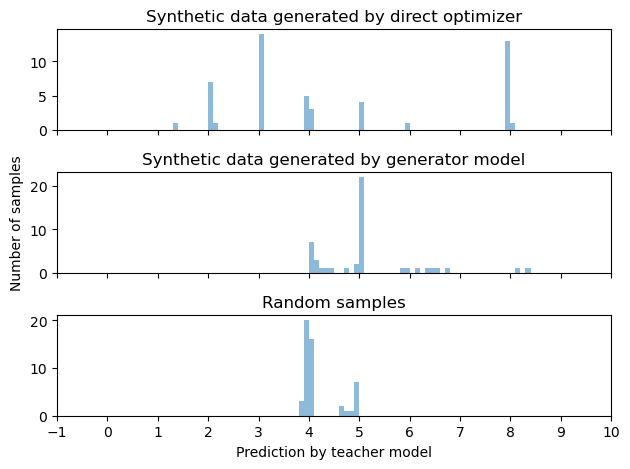

In [280]:
direct_optimizer_ytg = np.load("plots/direct_optimizer_y.npy")
generator_ytg = np.load("plots/generator_y.npy")
random_ytg = np.load("plots/random_y.npy")

fig, axs = plt.subplots(3, sharex=True)
axs[0].hist(direct_optimizer_ytg, bins=np.arange(-1, 10, 0.1), label='direct optimizer', alpha=0.5)
axs[0].set_title("Synthetic data generated by direct optimizer")
axs[1].hist(generator_ytg, bins=np.arange(-1, 10, 0.1), label='generator', alpha=0.5)
axs[1].set_title("Synthetic data generated by generator model")
axs[1].set_ylabel("Number of samples")
axs[2].hist(random_ytg, bins=np.arange(-1, 10, 0.1), label='random sample', alpha=0.5)
axs[2].set_title("Random samples")
axs[2].set_xlabel("Prediction by teacher model")
plt.xlim(-1, 10)
plt.xticks(np.arange(-1, 11, 1))
plt.tight_layout(h_pad=1)
fig.savefig('plots/histogram.png', dpi=200)